## Hybrid Fusion Multi-Modal Classifier

In [1]:
import numpy as np
from collections import Counter
import pandas as pd
import os
import PIL
import sklearn
import pickle
from sklearn import model_selection, metrics
from matplotlib import pyplot as plt
import tensorflow
from tensorflow import keras

In [2]:
from utils import data_utils, model_utils, models

#### Data Loading and Pre-processing

In [3]:
label_map = label_map = {
    'geol_geow': 0, 
    'geol_sed': 1, 
    'gphys_gen': 2, 
    'log_sum': 3, 
    'pre_site': 4, 
    'vsp_file': 5
}

In [4]:
doc_data = data_utils.DocumentData(label_map, 2020, drop_nans='or')

In [5]:
doc_data.load_text_data()
doc_data.text_train.shape

(4177, 2000)

In [ ]:
doc_data.load_image_data(image_size=200, n_pages=10)
doc_data.image_train.shape

In [ ]:
text_train = np.array([np.array([text] * 10) for text in doc_data.text_train])
text_val = np.array([np.array([text] * 10) for text in doc_data.text_val])
text_test = np.array([np.array([text] * 10) for text in doc_data.text_test])

#### Hybrid Fusion Combining Image C-LSTM & Text CNN Classifier with Early Fusion C-LSTM

##### Input Layers

In [ ]:
late_fusion_text_input = keras.layers.Input(shape=2000)
early_fusion_text_input = keras.layers.Input(shape=(10, 2000))
image_input = keras.layers.Input(shape=(10, 200, 200, 1))

##### Late fusion text learning pathway.
Text feature extraction & classification:

In [ ]:
lf_embeddings = keras.layers.Embedding(doc_data.vocab_length, 150, input_length=2000)(late_fusion_text_input)
lf_conv_1d = keras.layers.Conv1D(filters=200, kernel_size=7, activation='relu')(lf_embeddings)
lf_global_pooling = keras.layers.GlobalMaxPool1D()(lf_conv_1d)
lf_flatten = keras.layers.Flatten()(lf_global_pooling)
lf_dense_layer = keras.layers.Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(0.5))(lf_flatten)
lf_text_features = keras.layers.Dropout(0.3)(lf_dense_layer)

##### Late fusion image learning pathway.
Image feature extraction & classification:

In [ ]:
lf_conv_2d_1 = keras.layers.TimeDistributed(keras.layers.Conv2D(20, 7, activation='relu', padding='same'))(image_input)
lf_pool_2d_1 = keras.layers.TimeDistributed(keras.layers.MaxPooling2D(4))(lf_conv_2d_1)
lf_conv_2d_2 = keras.layers.TimeDistributed(keras.layers.Conv2D(50, 5, activation='relu', padding='valid'))(lf_pool_2d_1)
lf_pool_2d_2 = keras.layers.TimeDistributed(keras.layers.MaxPooling2D(4))(lf_conv_2d_2)
image_features = keras.layers.TimeDistributed(keras.layers.Flatten())(lf_pool_2d_2)
lf_lstm_1 = keras.layers.LSTM(1000, return_sequences=True)(image_features)
lf_image_features = keras.layers.LSTM(1000, dropout=0.5)(lf_lstm_1)

##### Merge Late Fusion Output

In [ ]:
lf_merge_features = keras.layers.concatenate([lf_text_features, lf_image_features])
late_fusion_features = keras.layers.Flatten()(lf_merge_features)

##### Early fusion learning pathway.

Text modality feature extraction:

In [ ]:
ef_embeddings = keras.layers.TimeDistributed(keras.layers.Embedding(doc_data.vocab_length, 150, input_length=2000), name='word_embeddings')(early_fusion_text_input)
ef_conv_1d = keras.layers.TimeDistributed(keras.layers.Conv1D(filters=200, kernel_size=7, activation='relu'), name='1d_convolutional_layer')(ef_embeddings)
ef_global_pooling = keras.layers.TimeDistributed(keras.layers.GlobalMaxPool1D(), name='max_pooling_layer')(ef_conv_1d)
ef_text_features = keras.layers.TimeDistributed(keras.layers.Flatten(), name='text_features')(ef_global_pooling)

Image modality feature extraction:

In [ ]:
ef_conv_2d_1 = keras.layers.TimeDistributed(keras.layers.Conv2D(20, 7, activation='relu', padding='same'))(image_input)
ef_pool_2d_1 = keras.layers.TimeDistributed(keras.layers.MaxPooling2D(4))(ef_conv_2d_1)
ef_conv_2d_2 = keras.layers.TimeDistributed(keras.layers.Conv2D(50, 5, activation='relu', padding='valid'))(ef_pool_2d_1)
ef_pool_2d_2 = keras.layers.TimeDistributed(keras.layers.MaxPooling2D(4))(ef_conv_2d_2)
ef_image_features = keras.layers.TimeDistributed(keras.layers.Flatten())(ef_pool_2d_2)

Joint feature representation:

In [ ]:
ef_joint_features = keras.layers.concatenate([ef_text_features, ef_image_features])

Classifier layers:

In [ ]:
ef_lstm_1 = keras.layers.LSTM(450, return_sequences=True)(ef_joint_features)
ef_lstm_2 = keras.layers.LSTM(1000)(ef_lstm_1)
early_fusion_features = keras.layers.Dropout(0.5)(ef_lstm_2)

##### Classification Output.
Concatenate early and late fusion output:

In [ ]:
hybrid_representation = keras.layers.concatenate([late_fusion_features, early_fusion_features])
output = keras.layers.Dense(6, activation='softmax')(hybrid_representation)

Build and compile model:

In [ ]:
model = keras.models.Model(inputs=[late_fusion_text_input, early_fusion_text_input, image_input], outputs=[output])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Train and evaluate model:

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min', restore_best_weights=True)

In [ ]:
history = model.fit(
    [doc_data.text_train, text_train, doc_data.image_train], 
    doc_data.y_train, 
    epochs=400, 
    validation_data=([doc_data.text_val, text_val, doc_data.image_val], doc_data.y_val), 
    callbacks=[early_stopping]
)

In [ ]:
model.evaluate([doc_data.text_test, text_test, doc_data.image_test], doc_data.y_test)

In [ ]:
y_hat = model.predict([doc_data.text_test, text_test, doc_data.image_test])

In [ ]:
y = np.argmax(doc_data.y_test, axis=-1)
y_hat = np.argmax(y_hat, axis=-1)

In [ ]:
labels = [label for label in label_map]
print(metrics.classification_report(y, y_hat, target_names=labels))

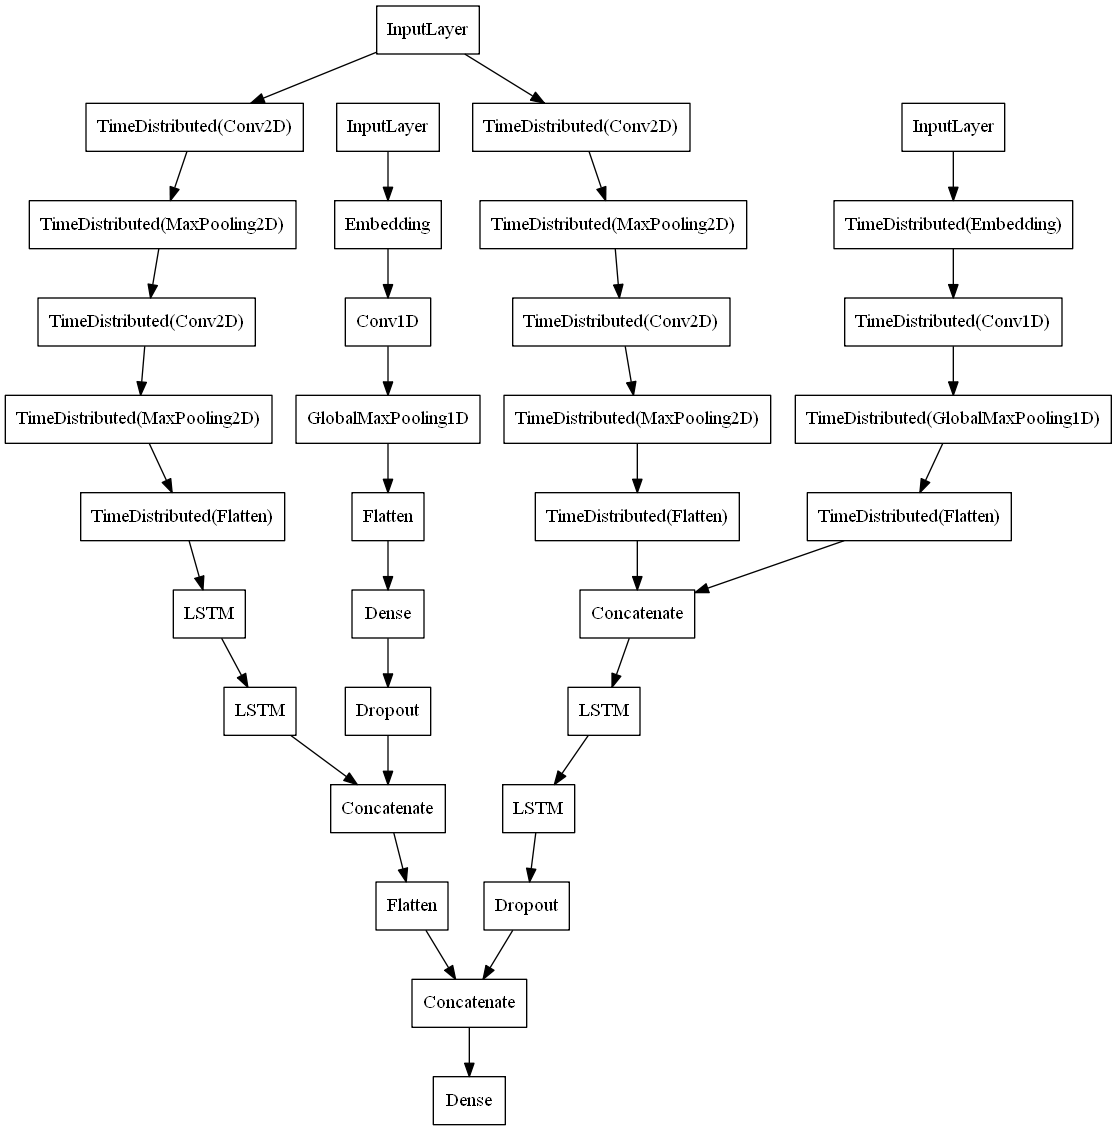

In [26]:
keras.utils.plot_model(model, show_layer_names=False)